In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import DictConfig

from highfrost.ogm.dataloaders.dl_evilog import EviLogDataLoader

#### Use the EviLOG data loader and plot the output

In [3]:
config = DictConfig({
    "data_dir": "/home/ssnyde9/dev/EviLOG/model/output/2024-02-12-12-51-25/Evaluation"
})

loader = EviLogDataLoader(config)

In [4]:
points, labels, input_img, target_img = loader.reset()

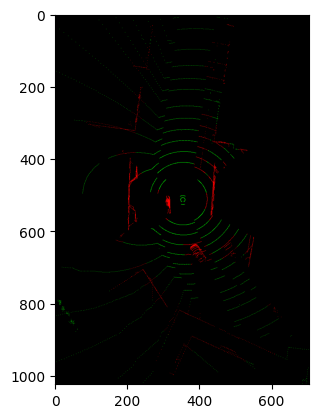

In [5]:
plt.imshow(input_img)

In [7]:
print(np.max(points[:, 0]), np.min(points[:, 0]))
print(np.max(points[:, 1]), np.min(points[:, 1]))

70.1 0.3
102.200005 0.1


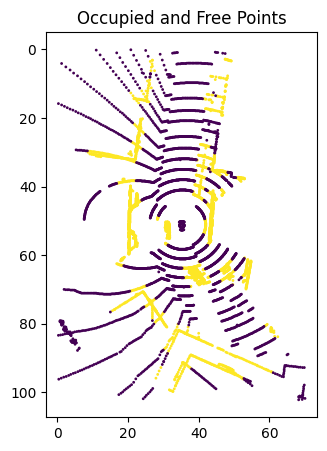

In [6]:
plt.subplots(figsize=(3.5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels, s=1)

plt.title("Occupied and Free Points")
plt.gca().invert_yaxis()

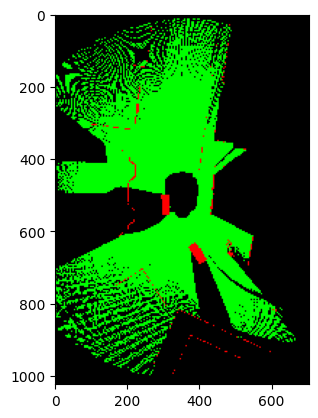

In [ ]:
plt.imshow(target_img)

#### Experimenting with how to properly load and decode EviLOG

In [ ]:
test_input_path = "/Users/shaysnyder/Desktop/data/evilog/Evaluation/inputs/0000000001.pcd.png"
test_label_path = "/Users/shaysnyder/Desktop/data/evilog/Evaluation/labels/0000000001.pcd.png"

In [ ]:
input = cv2.imread(test_input_path)
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
label = cv2.imread(test_label_path)
label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

### Original Input Point Cloud

(1024, 704, 3)
(1024, 704)
[  0 255]


Text(0.5, 1.0, 'Input')

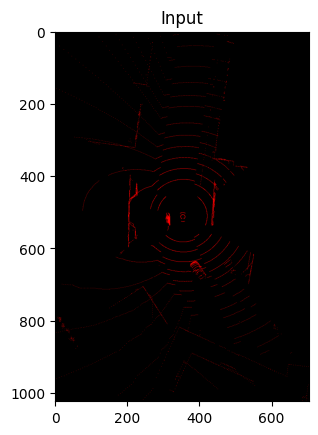

In [ ]:
print(input.shape)

mask = [0, 0, 0]
mask = np.array(mask)
mask = mask.astype(np.uint8)

print(np.all(input == mask, 2).shape)

bm = np.all(input == mask, 2)

input[~bm] = [255, 0, 0]
# input[bm] = [255, 255, 255]

print(np.unique(input))

plt.imshow(input)
plt.title("Input")

### Original Label

(1024, 704, 3)


Text(0.5, 1.0, 'Label')

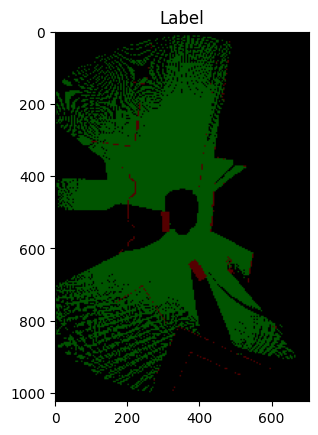

In [ ]:
label_resized = cv2.resize(
    label,
    (input.shape[1], input.shape[0]),
    interpolation=cv2.INTER_NEAREST
)


print(label_resized.shape)
plt.imshow(label_resized)
plt.title("Label")

#### Labeled Point Cloud

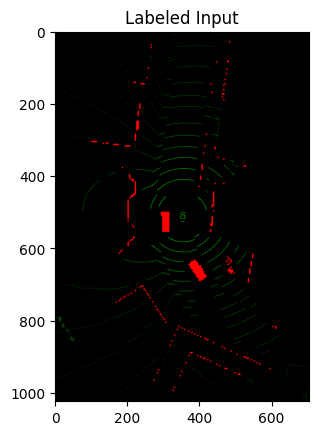

In [ ]:
labeled_input = np.ones_like(label_resized)
labeled_input *= 0
labeled_input = labeled_input.astype(np.uint8)

# add the occupied points to input
occupied_mask = [85, 0, 0]
boolean_occupied_mask = np.all(label_resized == occupied_mask, 2)
labeled_input[boolean_occupied_mask] = [255, 0, 0]

# blur the input
labeled_input_blur = cv2.blur(labeled_input, (30, 30))

information_mask = [0, 0, 0]
boolean_information_mask = np.all(labeled_input_blur == information_mask, 2)

input_red_mask = [255, 0, 0]

boolean_input_red_mask = np.all(input == input_red_mask, 2)

final_mask = np.logical_and(boolean_information_mask, boolean_input_red_mask)

labeled_input[final_mask] = [0, 255, 0]

plt.title("Labeled Input")
plt.imshow(labeled_input)

#### Extract the individual points

(6992, 2)
(3182, 2)


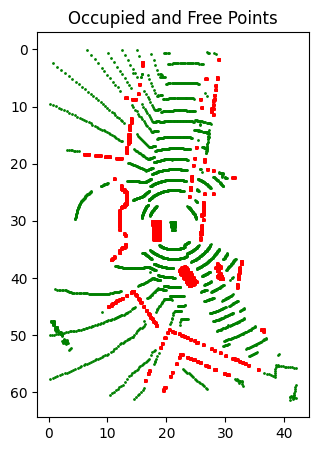

In [ ]:
red_mask = [255, 0, 0]
green_mask = [0, 255, 0]
axis_resolution = 0.06

boolean_red_mask = np.where(np.all(labeled_input == red_mask, 2))
boolean_green_mask = np.where(np.all(labeled_input == green_mask, 2))

occupied_points = np.concatenate([
    boolean_red_mask[1].reshape(-1, 1),
    boolean_red_mask[0].reshape(-1, 1)
], axis=1)

free_points = np.concatenate([
    boolean_green_mask[1].reshape(-1, 1),
    boolean_green_mask[0].reshape(-1, 1)
], axis=1)

occupied_points = occupied_points.astype(np.float32)
free_points = free_points.astype(np.float32)

occupied_points *= axis_resolution
free_points *= axis_resolution

print(occupied_points.shape)
print(free_points.shape)

plt.subplots(figsize=(3.5, 5))
plt.scatter(occupied_points[:, 0], occupied_points[:, 1], c="r", s=1)
plt.scatter(free_points[:, 0], free_points[:, 1], c="g", s=1)
plt.title("Occupied and Free Points")
plt.gca().invert_yaxis()

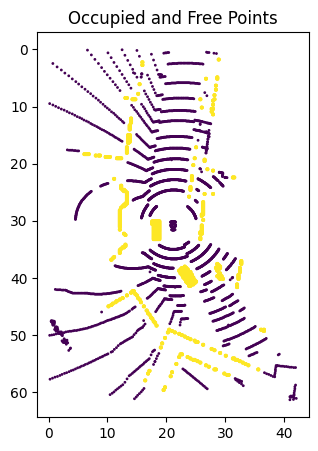

In [ ]:
all_points = np.concatenate([occupied_points, free_points], axis=0)
labels = np.concatenate([
    np.ones(occupied_points.shape[0]),
    np.zeros(free_points.shape[0])
])

plt.subplots(figsize=(3.5, 5))
plt.scatter(all_points[:, 0], all_points[:, 1], c=labels, s=1)
plt.title("Occupied and Free Points")
plt.gca().invert_yaxis()